Model loaded on cuda


You are using a model of type rt_detr to instantiate a model of type rt_detr_v2. This is not supported for all configurations of models and can yield errors.
Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r101vd_coco_o365 and are newly initialized: ['model.decoder.layers.0.encoder_attn.n_points_scale', 'model.decoder.layers.1.encoder_attn.n_points_scale', 'model.decoder.layers.2.encoder_attn.n_points_scale', 'model.decoder.layers.3.encoder_attn.n_points_scale', 'model.decoder.layers.4.encoder_attn.n_points_scale', 'model.decoder.layers.5.encoder_attn.n_points_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detected car with confidence 0.94 at location [1457.64, 1311.57, 2213.79, 1973.6]
Label Text: car
Detected car with confidence 0.86 at location [953.47, 1399.96, 1083.46, 1443.82]
Label Text: car
Detected truck with confidence 0.842 at location [1080.83, 1231.11, 1420.08, 1517.23]
Label Text: truck
Detected car with confidence 0.82 at location [-0.12, 1370.18, 271.6, 1450.37]
Label Text: car
Detected car with confidence 0.775 at location [716.47, 1385.53, 855.5, 1443.18]
Label Text: car
Detected person with confidence 0.746 at location [96.01, 1369.94, 171.19, 1513.21]
Label Text: person
Detected traffic light with confidence 0.746 at location [1139.05, 1111.77, 1177.63, 1164.0]
Label Text: traffic light
Detected car with confidence 0.599 at location [2190.93, 1330.55, 2289.82, 1366.02]
Label Text: car
Detected traffic light with confidence 0.508 at location [1462.85, 1273.66, 1485.9, 1296.11]
Label Text: traffic light


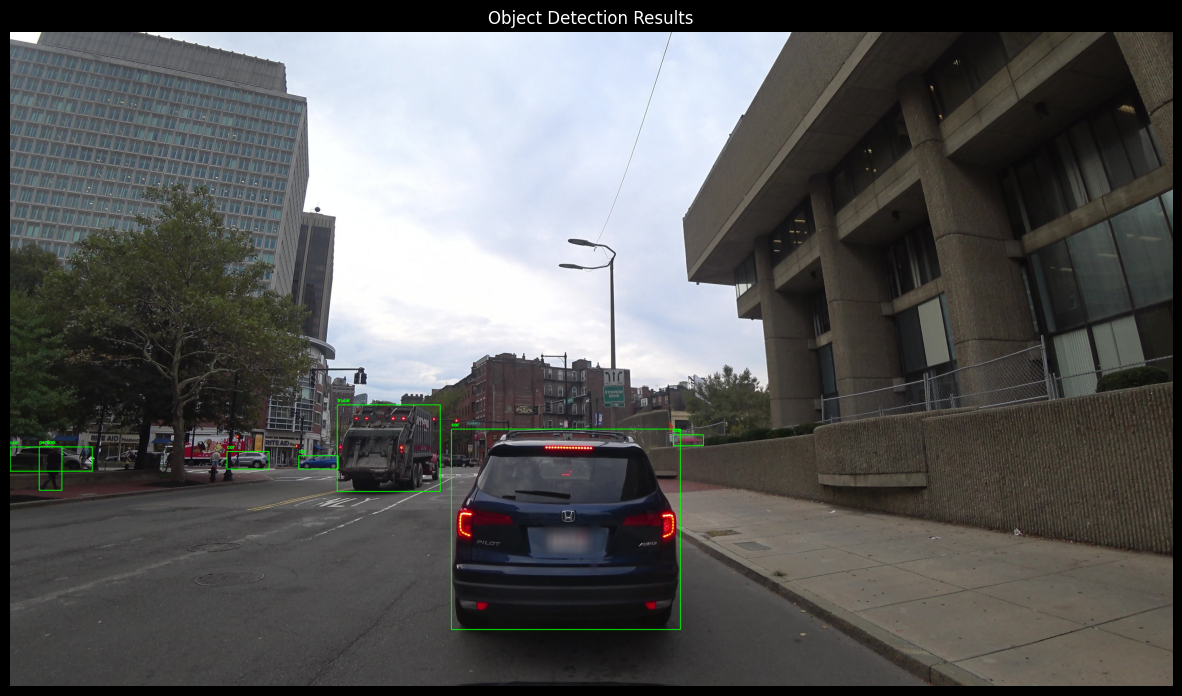

Masks shape: (7, 1, 2160, 3840)


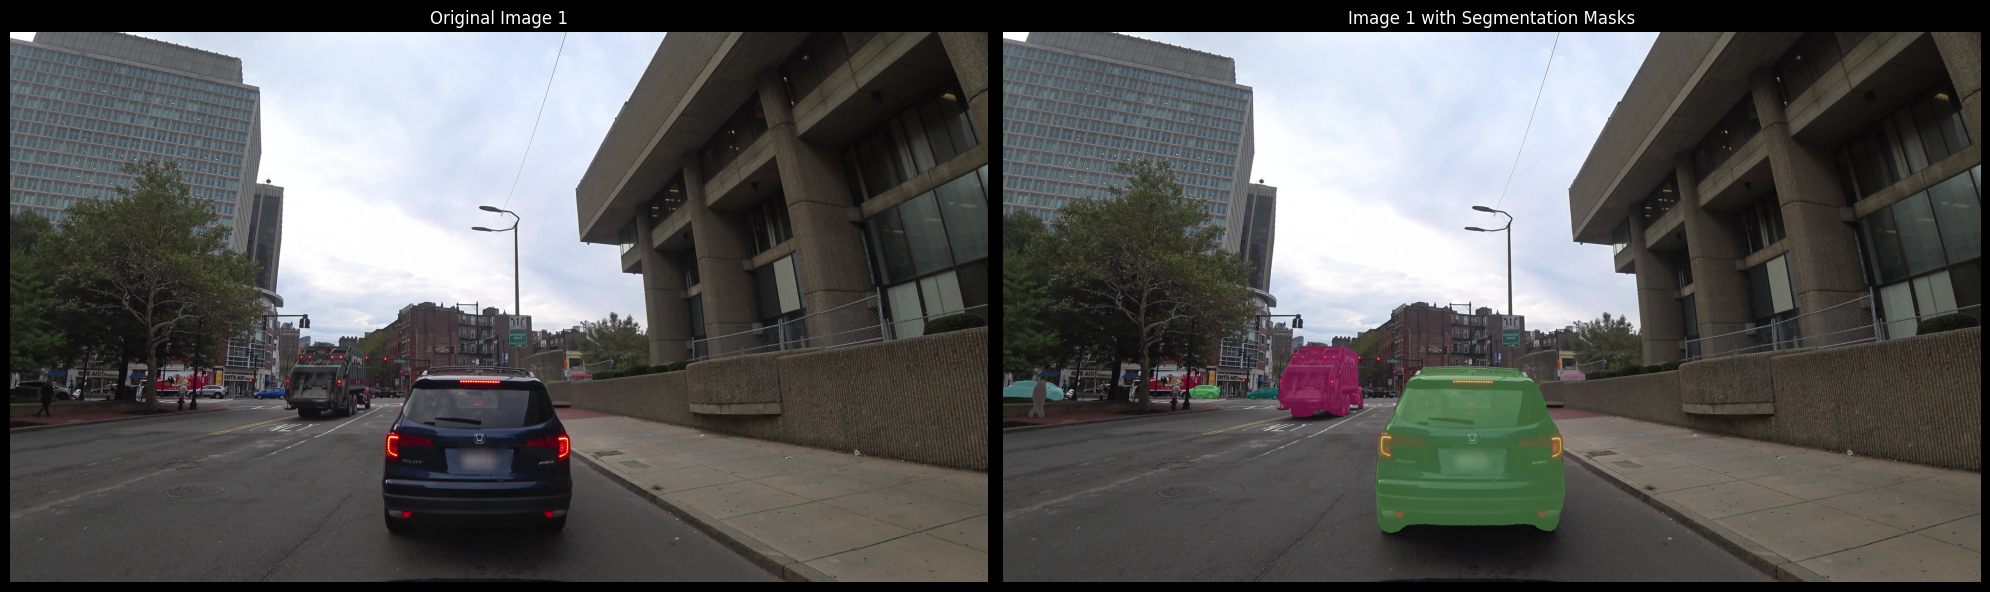

In [1]:
import torch
import torchvision
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights, raft_small, Raft_Small_Weights

import numpy as np
import torch
from torch.nn import functional as T_F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.utils import flow_to_image

from transformers import AutoImageProcessor, DeformableDetrForObjectDetection, RTDetrImageProcessor, RTDetrV2ForObjectDetection

import cv2
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

device = "cuda" if torch.cuda.is_available() else "cpu"

# model = raft_large(progress=True, weights=Raft_Large_Weights.DEFAULT).eval().to(device)
model = raft_small(progress=True, weights=Raft_Small_Weights.DEFAULT).eval().to(device)
print("Model loaded on", device)
# checkpoint = "/home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/sam2_checkpoints/sam2.1_hiera_large.pt"
# model_cfg = "/home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/thrid_party/sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
# Object Detection model
# ob_image_processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr")
# ob_model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr").to(device)

ob_image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r101vd_coco_o365")
ob_model = RTDetrV2ForObjectDetection.from_pretrained("PekingU/rtdetr_r101vd_coco_o365").to(device)

# plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if isinstance(img, torch.Tensor):
                img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.show()

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(1080, 1920)),
        ]
    )
    batch = transforms(batch)
    return batch

# Overlay masks on the images
def overlay_masks_on_image(image, masks, alpha=0.5):
    """
    Overlay segmentation masks on an image with different colors for each mask.
    
    Args:
        image: numpy array of shape (H, W, 3)
        masks: tensor of shape (num_masks, H, W) or (num_masks, 1, H, W)
        alpha: transparency factor for overlay
    """
    overlay = image.copy()
    
    # Generate random colors for each mask
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(masks), 3))
    
    for idx, mask in enumerate(masks):
        # Convert mask to numpy if it's a tensor
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        
        # Squeeze all dimensions of size 1 to get 2D mask
        mask = mask.squeeze()
        
        # If still not 2D, there's an issue - skip this mask
        if mask.ndim != 2:
            print(f"Warning: Mask {idx} has unexpected shape {mask.shape}, skipping")
            continue
        
        # Ensure mask is binary and matches image dimensions
        mask = mask > 0.5
        
        # Verify mask shape matches image shape
        if mask.shape[0] != image.shape[0] or mask.shape[1] != image.shape[1]:
            print(f"Warning: Mask shape {mask.shape} doesn't match image shape {image.shape[:2]}, skipping mask {idx}")
            continue
        
        # Create colored mask
        color_mask = np.zeros_like(image)
        color_mask[mask] = colors[idx]
        
        # Blend with original image
        overlay[mask] = cv2.addWeighted(overlay[mask], 1 - alpha, color_mask[mask], alpha, 0)
    
    return overlay

img_1 = torchvision.io.read_image("/home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/data/boston_cusfm_sequence/0000_zUKZjC0qOqVkYWxD-1n6EA/camera_0/000086.jpg")
img_2 = torchvision.io.read_image("/home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/data/boston_cusfm_sequence/0000_zUKZjC0qOqVkYWxD-1n6EA/camera_0/000087.jpg")
img_1_np = img_1.permute(1, 2, 0).cpu().numpy()
img_2_np = img_2.permute(1, 2, 0).cpu().numpy()

# Object Detection inference
inputs = ob_image_processor(images=[img_1_np], return_tensors="pt").to(device)
outputs = ob_model(**inputs)
# target_sizes should be a tensor of shape (batch_size, 2) with [height, width] for each image
target_sizes = torch.tensor([
    [img_1.shape[1], img_1.shape[2]], 
    # [img_2.shape[1], img_2.shape[2]]
    ])
results = ob_image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)

# Create a copy of the image for drawing bounding boxes
image_disp = img_1_np.copy()

bboxes = []
for result in results:
    bboxes_local = []
    for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {ob_model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
        
        # Draw bounding box
        # box format is [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = map(int, box)
        
        # Optionally add label text
        label_text = f"{ob_model.config.id2label[label.item()]}"
        conf_text = f"{round(score.item(), 3)}"
        print(f"Label Text: {label_text}")
        if label_text == "car" or label_text == "person" or label_text == "truck":
            image_disp = cv2.rectangle(image_disp, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_disp, label_text, (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            bbox = [x_min, y_min, x_max, y_max]
            bboxes_local.append(bbox)
    bboxes.append(bboxes_local)

# Plot the BBOX on the images
plt.figure(figsize=(15, 10))
plt.imshow(image_disp)
plt.axis('off')
plt.title('Object Detection Results')
plt.show()

# Run SAM2 model to segment the cars and pedestrians mainly.
disp_masks_images = []
all_masks = []
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    for image, image_bboxes in zip([img_1_np, img_2_np], bboxes):
        if len(image_bboxes) == 0:
            print("No bboxes detected, skipping image")
            disp_masks_images.append(image)
            all_masks.append([])
            continue
            
        # Set the image for SAM2 predictor
        predictor.set_image(image)
        
        # Convert bboxes to the format expected by SAM2
        # SAM2 expects boxes in format [x1, y1, x2, y2] as numpy array
        input_boxes = np.array(image_bboxes)
        
        # Predict masks for all bounding boxes
        masks, _, _ = predictor.predict(
            box=input_boxes,
            multimask_output=False
        )
        
        print(f"Masks shape: {masks.shape}")
        all_masks.append(masks)
        
        # Overlay masks on image
        image_with_masks = overlay_masks_on_image(image, masks, alpha=0.5)
        disp_masks_images.append(image_with_masks)

# Store masks for later use
masks = all_masks[0] if len(all_masks) > 0 else []

# Create overlays for both images
img_1_with_masks = disp_masks_images[0]
# img_2_with_masks = disp_masks_images[1]

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(img_1_np)
axes[0].set_title('Original Image 1')
axes[0].axis('off')

axes[1].imshow(img_1_with_masks)
axes[1].set_title('Image 1 with Segmentation Masks')
axes[1].axis('off')

plt.tight_layout()
plt.show()

img1_batch = preprocess(img_1).unsqueeze(0)
img2_batch = preprocess(img_2).unsqueeze(0)

with torch.no_grad():
    flow_predictions = model(img1_batch.to(device), img2_batch.to(device), num_flow_updates=128)
    predicted_flows = flow_predictions[-1]  # You're using the 5th-to-last iteration

    

In [2]:
ob_model.config.id2label

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorbike',
 4: 'aeroplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'sofa',
 58: 'pottedplant',
 59: 'bed',
 60: 'diningtable',
 61: 'toilet',
 62: 'tvmonitor',
 63: 'laptop',
 64: 

In [2]:
img_1.shape

torch.Size([3, 2160, 3840])

In [3]:
img_1_np.shape[::-1]

(3, 3840, 2160)

In [4]:
# pred64 = flow_predictions[-1]
# pred128 = flow_predictions_128[-1]

# # Find the average difference between the two predictions
# diff = torch.abs(pred64 - pred128)
# avg_diff = torch.mean(diff).item()
# print(f"Average difference between 64 and 128 updates: {avg_diff:.6f}")

In [5]:
# predicted_flows = flow_predictions[-1]
# predicted_flows.shape

# img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

# flow_imgs = flow_to_image(predicted_flows.cpu())

# grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
# plot(grid)

In [6]:
# predicted_flows.max(), predicted_flows.min()

In [7]:
_, h, w = img1_batch[0].shape

predicted_flows.shape
upsampled_predicted_flows = T_F.interpolate(
    predicted_flows,
    size=(img_1.shape[1], img_1.shape[2]),
    mode="bicubic",
    align_corners=False,
)

scale_factor_h = h / predicted_flows.shape[2]
scale_factor_w = w / predicted_flows.shape[3]

upsampled_predicted_flows[:, 0, :, :] *= scale_factor_w
upsampled_predicted_flows[:, 1, :, :] *= scale_factor_h

# predicted_flows_np = upsampled_predicted_flows[0].cpu().permute(1, 2, 0).numpy()\
predicted_flows_np = predicted_flows[0].cpu().permute(1, 2, 0).numpy()

In [8]:
img_1.shape, predicted_flows.shape, upsampled_predicted_flows.shape

(torch.Size([3, 2160, 3840]),
 torch.Size([1, 2, 1080, 1920]),
 torch.Size([1, 2, 2160, 3840]))

In [9]:
(2160/2), (3840/2)

(1080.0, 1920.0)

In [10]:
img1_batch.shape, img_1.shape

(torch.Size([1, 3, 1080, 1920]), torch.Size([3, 2160, 3840]))

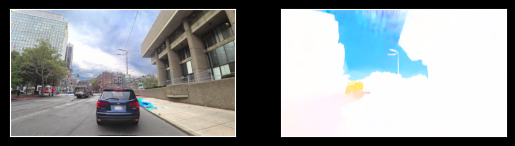

In [11]:
img1_og_batch = img1_batch

flow_imgs = flow_to_image(upsampled_predicted_flows.cpu())

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_og_batch, flow_imgs)]
plot(grid)

In [12]:
motion_threshold = 10.0 
noisy_motion_mask = (predicted_flows_np > motion_threshold).astype(np.uint8) * 255

In [13]:
# Find Background Motion with RANSAC
n_steps = 10
y_indices, x_indices = np.mgrid[n_steps//2:h:n_steps, n_steps//2:w:n_steps]
src_pts = np.stack((x_indices.ravel(), y_indices.ravel()), axis=-1).astype(np.float32)

flow_at_pts = predicted_flows_np[y_indices.ravel(), x_indices.ravel()]

dst_pts = src_pts + flow_at_pts

# --- 3. Find the Homography with RANSAC ---
# This matrix 'H' now describes the camera's ego-motion
# The 'ransac_mask' flags outliers (moving objects)
H, ransac_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0, maxIters=100000)

if H is None:
    print("RANSAC failed to find a valid homography. Skipping frame.")
else:
    print("RANSAC success. Homography matrix 'H' found.")

RANSAC success. Homography matrix 'H' found.


In [14]:
H

array([[ 9.99081418e-01,  2.23739354e-03, -2.88335222e-01],
       [-3.60229630e-04,  1.00049491e+00,  2.86470280e-01],
       [-6.29665062e-07,  1.30771387e-06,  1.00000000e+00]])

In [15]:
H

array([[ 9.99081418e-01,  2.23739354e-03, -2.88335222e-01],
       [-3.60229630e-04,  1.00049491e+00,  2.86470280e-01],
       [-6.29665062e-07,  1.30771387e-06,  1.00000000e+00]])

In [16]:
# --- 1. Create a dense grid of *all* source coordinates ---
all_y, all_x = np.mgrid[0:h, 0:w].astype(np.float32)
all_src_pts = np.stack((all_x.ravel(), all_y.ravel()), axis=-1)

# --- 2. Predict the background motion with H ---
# Use perspectiveTransform to apply H to all points
# This tells us where each background pixel *should* have moved
all_dst_pts_pred = cv2.perspectiveTransform(all_src_pts.reshape(1, -1, 2), H)
all_dst_pts_pred = all_dst_pts_pred.reshape(-1, 2)

# --- 3. Calculate the *predicted* flow ---
flow_pred = (all_dst_pts_pred - all_src_pts).reshape(h, w, 2)

# --- 4. Get the *actual* flow (from RAFT) ---
flow_actual = predicted_flows_np

# --- 5. Find the error ---
# Subtract predicted flow from actual flow and find the magnitude
flow_error = np.linalg.norm(flow_actual - flow_pred, axis=-1)

# --- 6. Threshold the error to get the final mask ---
# Any pixel with a flow error > 5 pixels is a "moving object"
motion_threshold = 20.0 
noisy_motion_mask = (flow_error > motion_threshold).astype(np.uint8) * 255

print("Noisy motion mask created.")
# You can view this mask: cv2.imshow("Noisy Mask", noisy_motion_mask)

Noisy motion mask created.


In [17]:
flow_error.max(), flow_error.min(), flow_error.mean(), flow_error.std()

(np.float32(63.352955),
 np.float32(0.00022630717),
 np.float32(6.4302826),
 np.float32(13.905147))

In [27]:
(flow_actual - flow_pred).shape

(1080, 1920, 2)

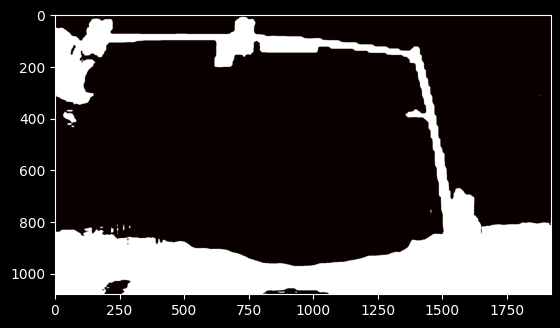

In [33]:
plt.imshow(noisy_motion_mask, cmap='hot')

Found 12 intersection masks (optical flow + segmentation)


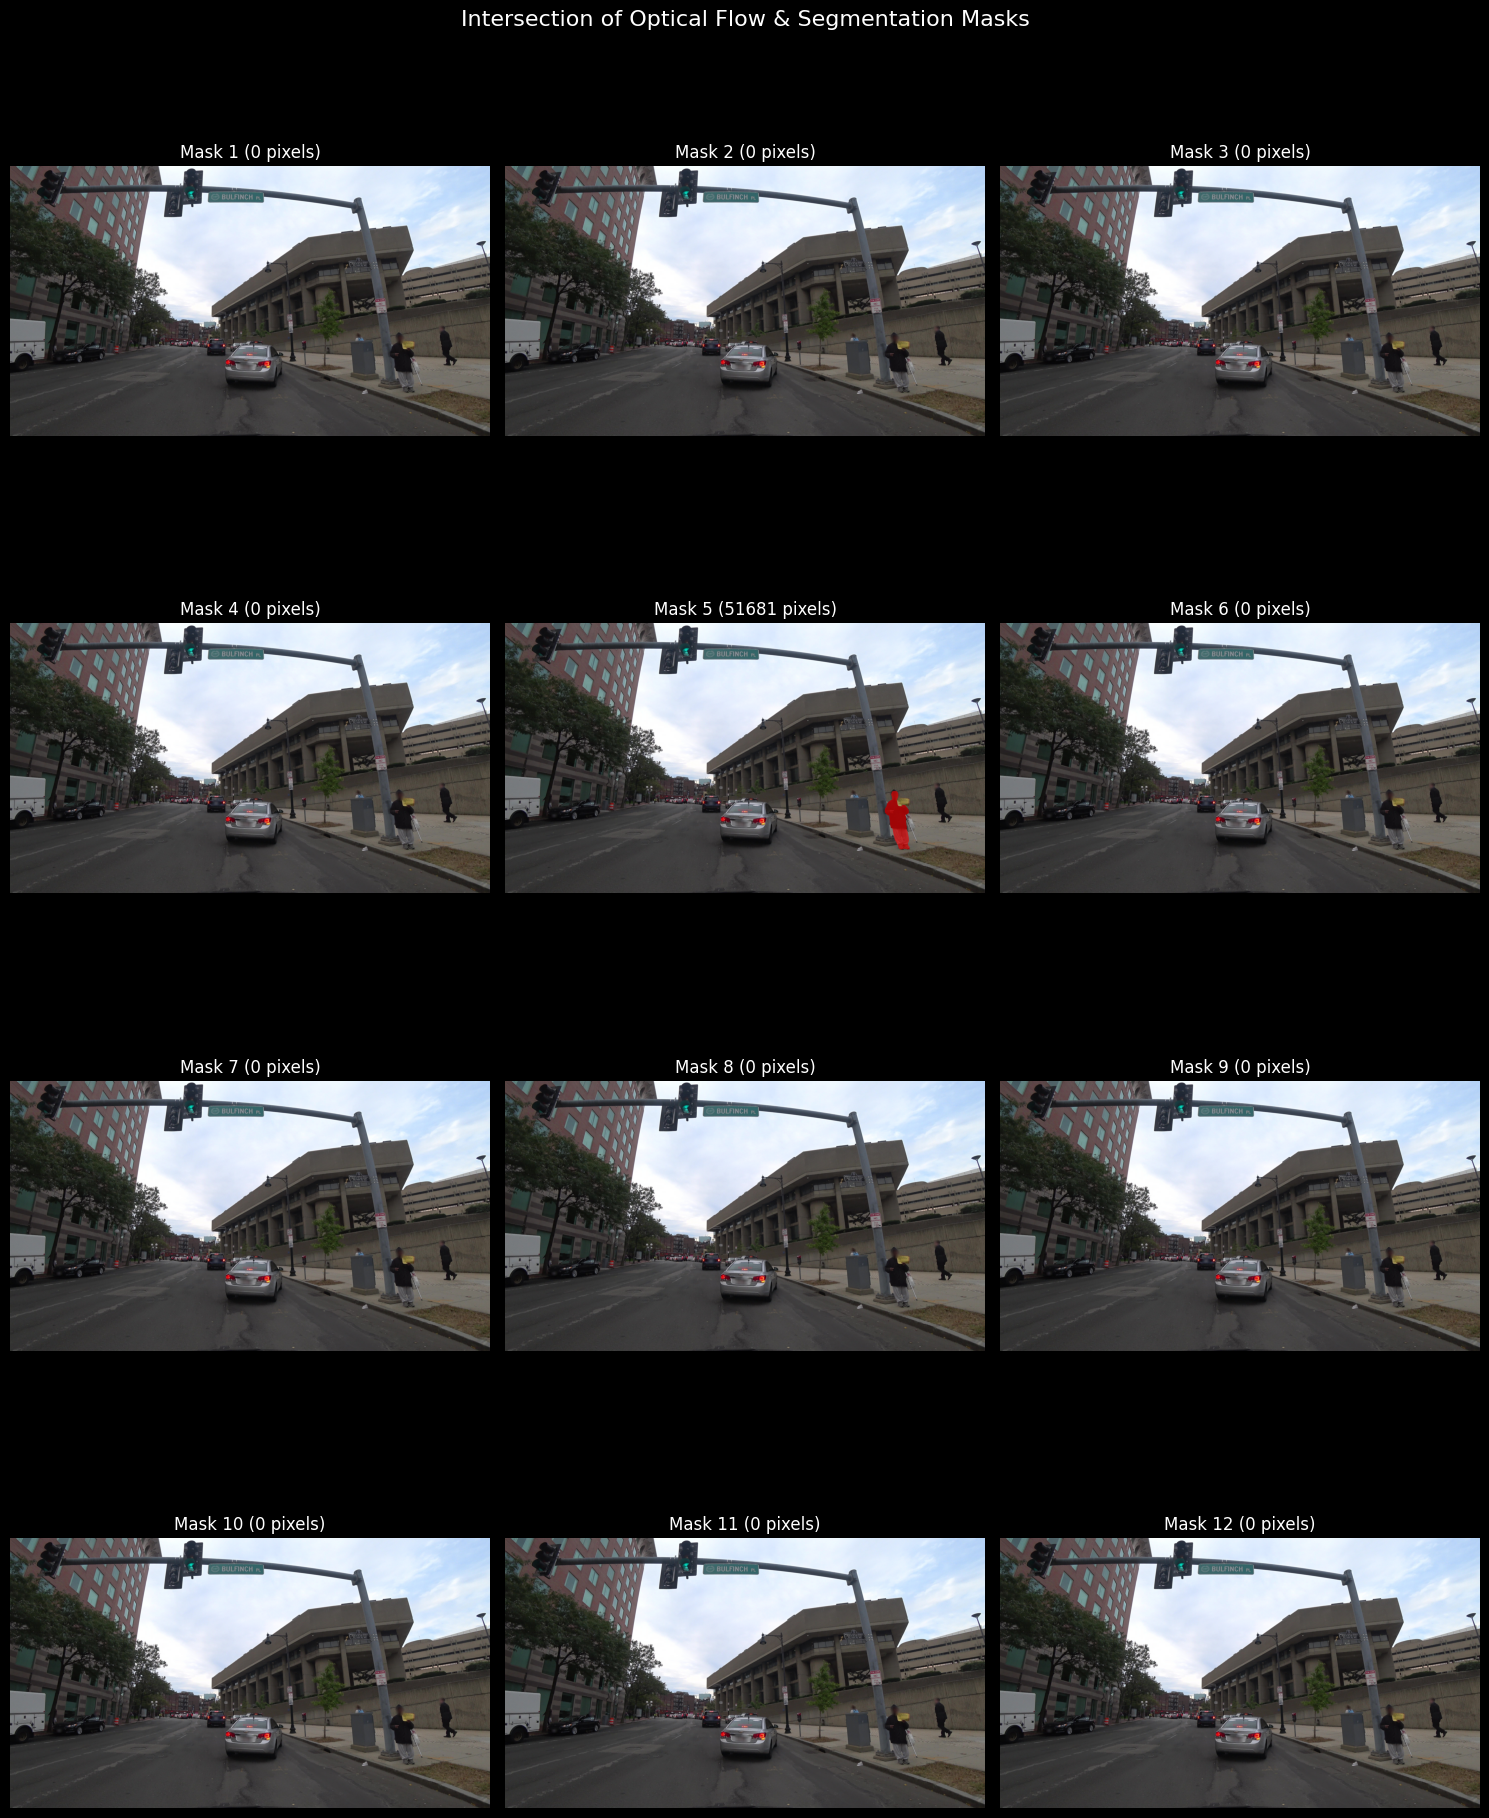

In [32]:
upsampled_noisy_motion_mask = T_F.interpolate(
    torch.as_tensor(noisy_motion_mask).unsqueeze(0).unsqueeze(0).float(),
    size=(img_1.shape[1], img_1.shape[2]),
    mode="nearest-exact",
)

of_masks = []
for mask in masks:
    intersection = np.logical_and(upsampled_noisy_motion_mask.squeeze().cpu().numpy() > 0, mask > 0)
    of_masks.append(intersection)

# New plot function for better visualization
def plot_masks_grid(masks, img=None, title="Masks", cols=3):
    """
    Plot masks in a grid layout with optional background image.
    
    Args:
        masks: list of 2D numpy arrays (masks)
        img: optional background image to overlay masks on
        title: title for the figure
        cols: number of columns in the grid
    """
    n_masks = len(masks)
    
    if n_masks == 0:
        print("No masks to display!")
        return
    
    rows = (n_masks + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    
    # Flatten axes array for easier indexing
    if n_masks == 1:
        axes = np.array([axes])
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = np.array(axes) if not isinstance(axes, np.ndarray) else axes
    
    for idx, mask in enumerate(masks):
        ax = axes[idx]
        
        # Ensure mask is a 2D numpy array
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        
        # Squeeze to remove any singleton dimensions
        mask = np.squeeze(mask)
        
        # Ensure mask is 2D
        if mask.ndim != 2:
            print(f"Warning: Mask {idx} has unexpected dimensions {mask.ndim}, skipping")
            ax.axis('off')
            continue
        
        if img is not None:
            # Verify mask shape matches image shape
            if mask.shape[0] != img.shape[0] or mask.shape[1] != img.shape[1]:
                print(f"Warning: Mask shape {mask.shape} doesn't match image shape {img.shape[:2]}, skipping mask {idx}")
                ax.axis('off')
                continue
            
            # Show image with mask overlay
            overlay = img.copy().astype(np.float32)
            mask_bool = mask > 0.5 if mask.dtype != bool else mask
            
            # Check if mask has any True values
            if np.any(mask_bool):
                # Create colored mask overlay
                color = np.array([255.0, 0.0, 0.0])  # Red color for mask
                
                # Blend - overlay the red color on the image
                alpha = 0.6
                # Apply color overlay only to the masked region
                overlay[mask_bool] = overlay[mask_bool] * (1 - alpha) + color * alpha
            
            ax.imshow(overlay.astype(np.uint8))
            ax.set_title(f'Mask {idx + 1} ({np.sum(mask_bool)} pixels)')
        else:
            # Just show the mask
            ax.imshow(mask, cmap='gray')
            ax.set_title(f'Mask {idx + 1}')
        
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(n_masks, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display intersection masks with the original image
print(f"Found {len(of_masks)} intersection masks (optical flow + segmentation)")
if len(of_masks) > 0:
    plot_masks_grid(of_masks, img=img_1_np, title="Intersection of Optical Flow & Segmentation Masks", cols=3)
else:
    print("No moving objects detected in the intersection!")

In [29]:
upsampled_noisy_motion_mask = T_F.interpolate(
    torch.as_tensor(noisy_motion_mask).unsqueeze(0).unsqueeze(0).float(),
    size=(img_1.shape[1], img_1.shape[2]),
    mode="nearest-exact",
)

of_masks = []
for mask in masks:
    intersection = np.logical_and(upsampled_noisy_motion_mask.squeeze().cpu().numpy() > 0, mask.cpu().numpy() > 0)
    of_masks.append(intersection)

# New plot function for better visualization
def plot_masks_grid(masks, img=None, title="Masks", cols=3):
    """
    Plot masks in a grid layout with optional background image.
    
    Args:
        masks: list of 2D numpy arrays (masks)
        img: optional background image to overlay masks on
        title: title for the figure
        cols: number of columns in the grid
    """
    n_masks = len(masks)
    
    if n_masks == 0:
        print("No masks to display!")
        return
    
    rows = (n_masks + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    
    # Flatten axes array for easier indexing
    if n_masks == 1:
        axes = np.array([axes])
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = np.array(axes) if not isinstance(axes, np.ndarray) else axes
    
    for idx, mask in enumerate(masks):
        ax = axes[idx]
        
        if img is not None:
            # Show image with mask overlay
            overlay = img.copy().astype(np.float32)
            mask_bool = mask > 0.5 if mask.dtype != bool else mask
            
            # Check if mask has any True values
            if np.any(mask_bool):
                # Create colored mask overlay
                color = np.array([255.0, 0.0, 0.0])  # Red color for mask
                
                # Blend - overlay the red color on the image
                alpha = 0.6
                overlay[mask_bool] = overlay[mask_bool] * (1 - alpha) + color * alpha
            
            ax.imshow(overlay.astype(np.uint8))
            ax.set_title(f'Mask {idx + 1} ({np.sum(mask_bool)} pixels)')
        else:
            # Just show the mask
            ax.imshow(mask, cmap='gray')
            ax.set_title(f'Mask {idx + 1}')
        
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(n_masks, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display intersection masks with the original image
print(f"Found {len(of_masks)} intersection masks (optical flow + segmentation)")
if len(of_masks) > 0:
    plot_masks_grid(of_masks, img=img_2_np, title="Intersection of Optical Flow & Segmentation Masks", cols=3)
else:
    print("No moving objects detected in the intersection!")

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
torch.as_tensor(noisy_motion_mask).unsqueeze(0).shape

torch.Size([1, 1080, 1920])

In [ ]:
3840/2

1920.0